# Import Packages

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import panel as pn
import stumpy
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

pn.extension()

# Generate Data

In [2]:
rows = 6
columns = 365 * 5
data = np.random.rand(columns * rows).reshape(columns, rows)
dfs = pd.DataFrame(data, columns=["A", "B", "C", "D", "E", "F"])
dfs

,A,B,C,D,E,F
0,0.367286,0.817984,0.557395,0.193198,0.928448,0.461126
1,0.322848,0.510539,0.260328,0.858135,0.823340,0.441832
2,0.868103,0.970521,0.023854,0.350967,0.853073,0.669519
3,0.700467,0.284216,0.951411,0.460535,0.567530,0.594587
4,0.274663,0.317117,0.139062,0.068992,0.909450,0.210913
...,...,...,...,...,...,...
1820,0.466826,0.411494,0.543446,0.295374,0.552960,0.191297
1821,0.006036,0.840068,0.323532,0.956559,0.742086,0.142077
1822,0.453672,0.617093,0.066222,0.602997,0.792687,0.103146
1823,0.494319,0.922743,0.480959,0.276443,0.769901,0.725831


# Compute Matrix Profiles

In [3]:
mps = {}
m = 60

for colname in dfs.columns:
    mps[colname] = stumpy.stump(dfs[colname].values, m=m)

# Create Interactive Dashboard

Column
    [0] Row
        [0] Select(options=['A', 'B', 'C', ...], value='A', width=100)
        [1] CheckButtonGroup(name='Normalize', options=['Z-Normalize'], value=['Z-Normalize'], width=100)
        [2] TextInput(value='1422', width=100)
        [3] IntSlider(end=1825, value=1422, width=800)
    [1] Row
        [0] Matplotlib(Figure)
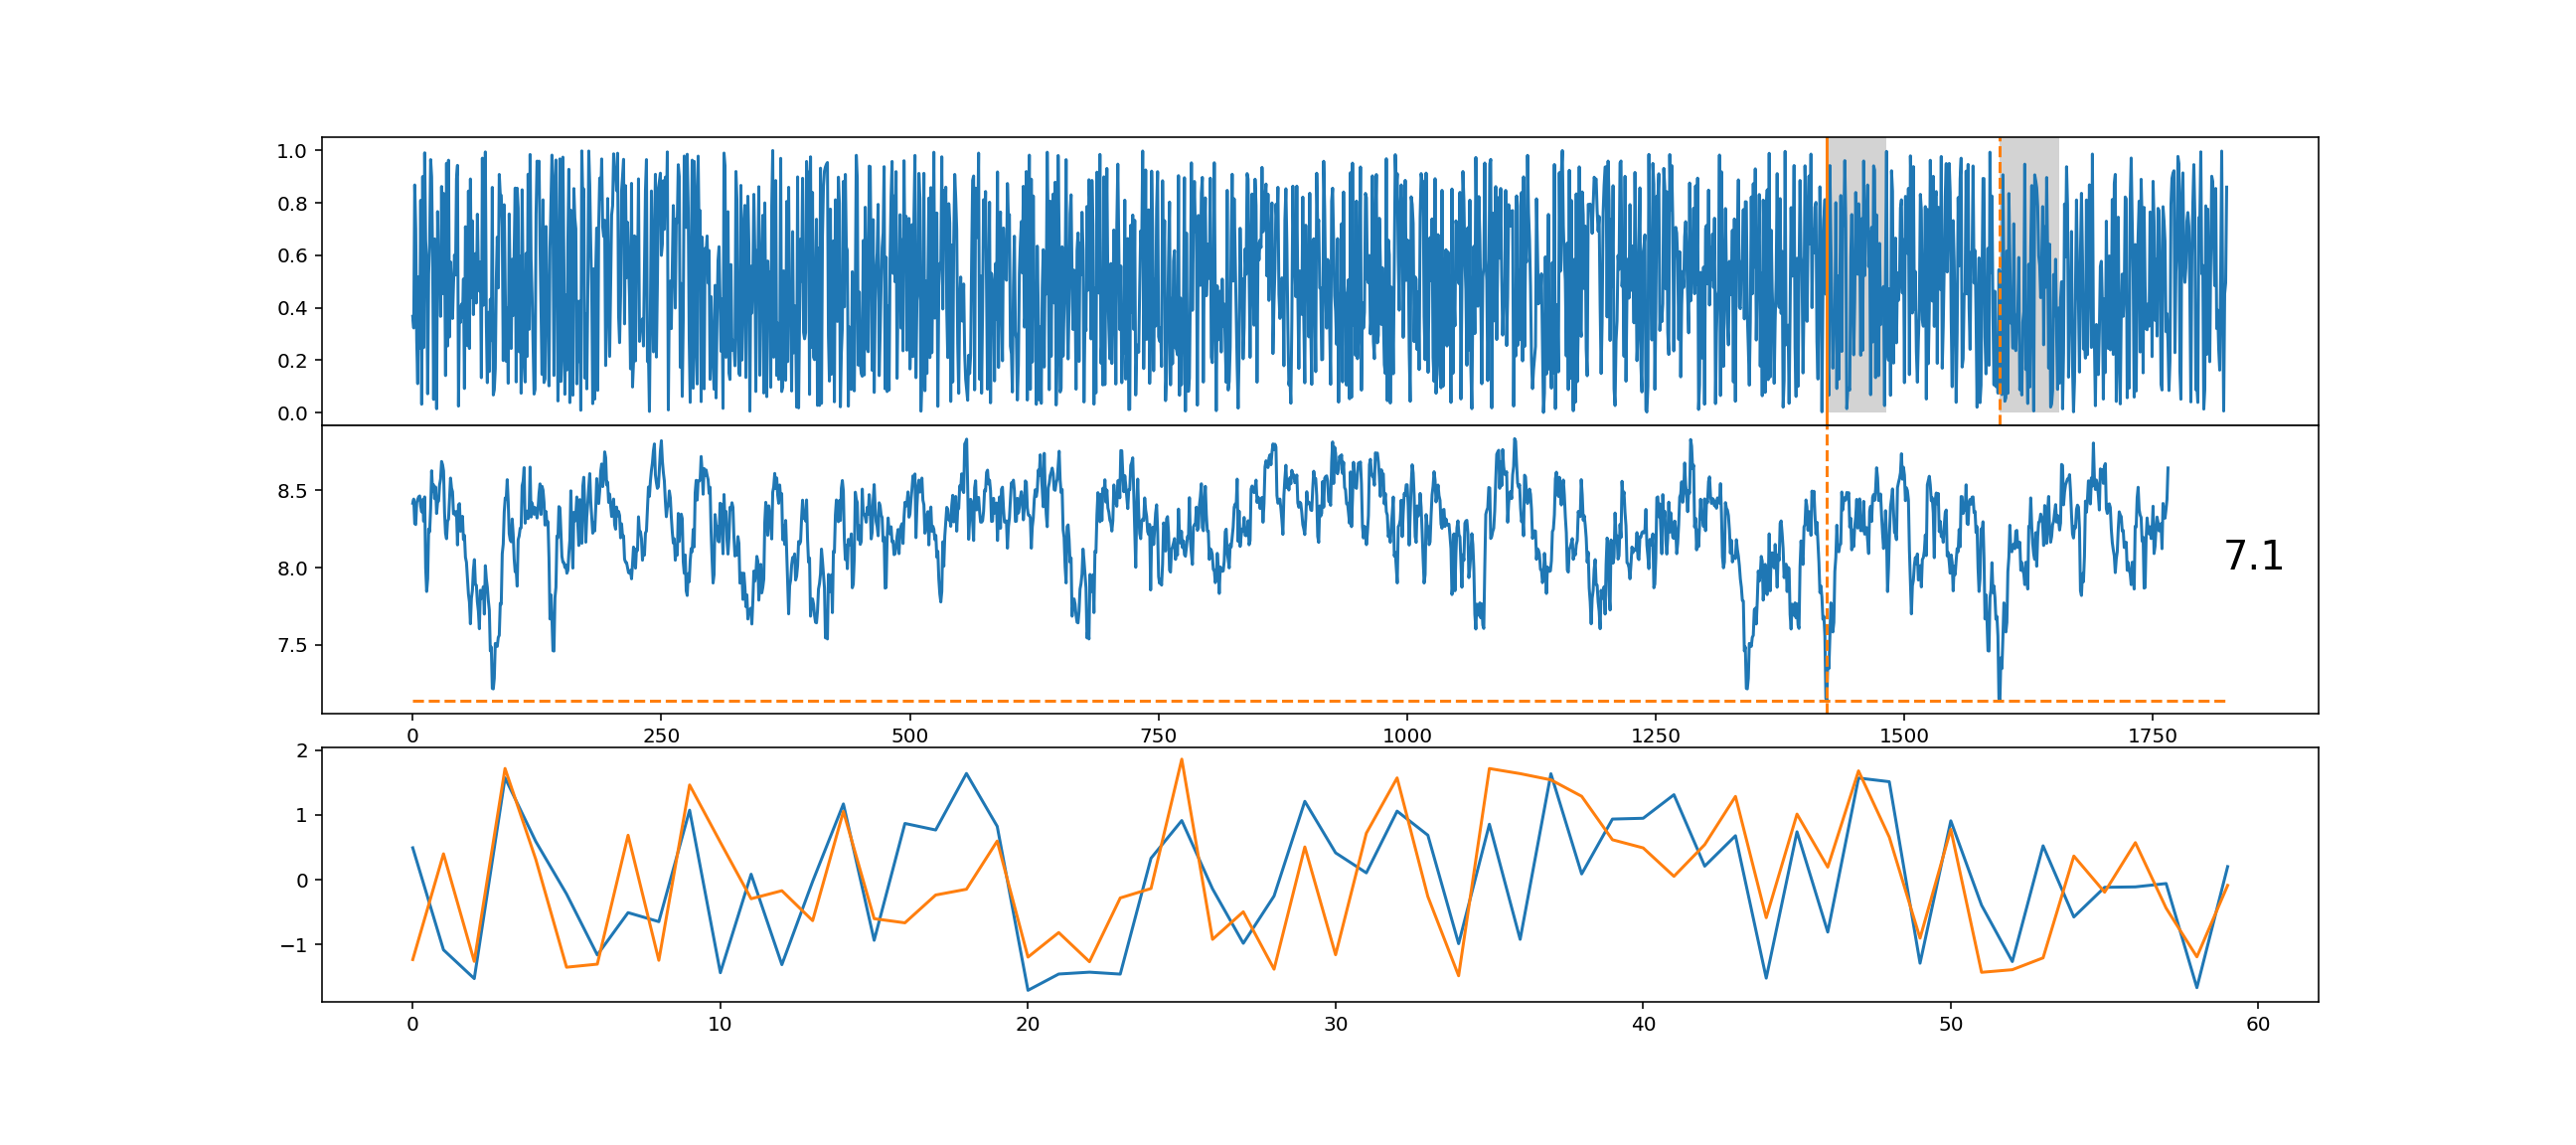

In [4]:
select_plot = pn.widgets.Select(name='', options=sorted(list(dfs.columns)), width=100)
normalize_btn = pn.widgets.CheckButtonGroup(name='Normalize', value=['Z-Normalize'], options=['Z-Normalize'], width=100)
idx_slider = pn.widgets.IntSlider(value=0, start=0, end=len(dfs), width=800)
txt_input = pn.widgets.TextInput(value="0", width=100)


def display_raw(dfs, mps, colname, m=m, idx=None):
    fig = Figure(figsize=(18,8))
    shared_spec = gridspec.GridSpec(3, 1, hspace=0)
    unshared_spec = gridspec.GridSpec(3, 1)
    raw_ax = fig.add_subplot(shared_spec[0, :])
    mp_ax = fig.add_subplot(shared_spec[1, :], sharex=raw_ax)
    overlap_ax = fig.add_subplot(unshared_spec[2, :])
    
    raw_ax.plot(dfs[colname])
    
    mp = mps[colname]
    mp_ax.plot(mp[:, 0])
    
    if idx is None:
        idx = int(np.argsort(mp[:, 0])[0])
    nn_idx = mp[:, 1][idx]
    distance = mp[idx, 0]
    
    idx_slider.value = idx
    txt_input.value = str(idx)
    
    raw_ax.axvline(x=idx, color="C1")
    raw_ax.axvline(x=nn_idx, linestyle="dashed", color="C1")
    
    rect = Rectangle((idx, 0), m, 40, facecolor='lightgrey')
    raw_ax.add_patch(rect)
    rect = Rectangle((nn_idx, 0), m, 40, facecolor='lightgrey')
    raw_ax.add_patch(rect)
    
    mp_ax.axvline(x=idx, linestyle="dashed", color="C1")
    mp_ax.hlines(distance, 0, len(dfs), linestyle="dashed", color="C1")
    ymin, ymax = mp_ax.get_ylim()
    xmin, xmax = mp_ax.get_xlim()
    mp_ax.text(xmax * 0.95, ymin+(ymax-ymin)/2, f'{np.round(distance,1)}', color="black", fontsize=20)
    
    
    # Need to z-normalize
    if 'Z-Normalize' in normalize_btn.value:
        overlap_ax.plot(stumpy.core.z_norm(dfs[colname].values[idx:idx+m]))
        overlap_ax.plot(stumpy.core.z_norm(dfs[colname].values[nn_idx:nn_idx+m]))
    else:
        overlap_ax.plot(dfs[colname].values[idx:idx+m])
        overlap_ax.plot(dfs[colname].values[nn_idx:nn_idx+m])
    


    return fig


plot = pn.Row(display_raw(dfs, mps, "A"), align='start')


def replace_plot(event):
    colname = event.new
    plot[0] = display_raw(dfs, mps, colname=colname)

    
def update_plot(event):
    colname = select_plot.value
    plot[0] = display_raw(dfs, mps, colname=colname)


def move_idx(event):
    idx = event.new
    txt_input.value = str(idx)
    colname = select_plot.value
    plot[0] = display_raw(dfs, mps, colname=colname, idx=idx)


def update_slider(event):
    idx = int(event.new)
    idx_slider.value = idx
    colname = select_plot.value
    plot[0] = display_raw(dfs, mps, colname=colname, idx=idx)
    

select_plot.param.watch(replace_plot, 'value')
normalize_btn.param.watch(update_plot, 'value')
txt_input.param.watch(update_slider, 'value')
idx_slider.param.watch(move_idx, 'value')

p = pn.Column(
        pn.Row(select_plot, normalize_btn, txt_input, idx_slider),
        plot,
    )

p

In [5]:
p.save("test.html")